**NAME : JUI VITTHAL KORATKAR   
STUDENT ID : 20200315   
SUBJECT : ACM40960 - PROJECT IN MATHS MODELING**




# Installing and Importing the required packages and libraries

In [ ]:
#Installation all the packages required for the project
%%capture
pip install numpy opencv-python pillow tensorflow keras imutils scikit-learn matplotlib scikit-plot -q kaggle -q gwpy



In [ ]:
# Importing timer for measuring total run time and model training time
from time import process_time
from mlxtend.plotting import plot_learning_curves

# Defining Start time
start_time = process_time()

#Importing all the necessary libraries
import json
import math
import os
import gc
import scipy
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from glob import glob
from numpy import expand_dims
from keras import applications
from tqdm import tqdm
from keras.models import load_model
from sklearn import metrics
from keras import backend as K
import seaborn as sns
from os import listdir
import pandas as pd
from skimage import io

from functools import partial
from sklearn import metrics
from collections import Counter
import itertools
from google.colab.patches import cv2_imshow
from matplotlib.image import imread
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from keras.utils.np_utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import cohen_kappa_score, accuracy_score

# Importing Data from Kaggle

In [ ]:
#uploading the json file which contains authors' username and key for accessing the kaggle data(The json file is pushed to git named as kaggle.json)
from google.colab import files
files.upload()
# upload the kaggle.json file( contains username and key ) which is uploaded on git and it is used for authentication purpose to fetch the data from kaggle.

Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"juikoratkar","key":"ad135e30db699bbb0f66e962766cdefd"}'}

In [ ]:
#Create a Kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#Copy the kaggle.json file to the created folder
! cp kaggle.json ~/.kaggle/

In [ ]:
#Give the permission to json file to act further
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download the necessary dataset by mentioning the dataset name
! kaggle datasets download paultimothymooney/breast-histopathology-images  # This snipped will take some time to run as it involves dowaloading of the dataset

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Unzip the downloaded file to the mentioned folder
%%capture
! unzip breast-histopathology-images.zip  # This snipped will take some time to run as it involves unzipping of the dataset

In [ ]:
%%capture
pip install matplotlib==3.1.3 

# Reading and understanding the data

Reading the path of the dataset and counting the toal no of folders in it


In [ ]:
image_path = "/content/IDC_regular_ps50_idx5"                          # assigns the directory of the dataset to the variable image_path
dir_folder = listdir(image_path)                                       # It returns a list containing the names of the entries in the directory given by path
print(f'Total Number of folders in the dataset are :{len(dir_folder)}')  # Counts the total no of folders in the main folder


Total Number of folders in the dataset are :279


Code to count the toal no patches and the no of patches for class 0 (Non IDC :) and class 1(IDC :) patches

In [ ]:
class_0_total = 0                                                      # a variable is declared to count the class 0 images
class_1_total = 0                                                      # a variable is declared to count the class 1 images

                                                                    
patient_ids = listdir(image_path)                                      # It returns a list containing the names of the entries in the directory given by path

# for loop for separating class 0 and class 1  image paths and listing them into class_NonIDC_files and class_IDC_files respectively
for patient_id in patient_ids:
    class_NonIDC_files = listdir(image_path + '/' + patient_id + '/0') # Listing out all the patient ids' with class 0 type (Benign) present in the dataset
    class_IDC_files = listdir(image_path + '/' +  patient_id + '/1')   # Listing out all the patient ids' with class 1 type (Malignant) present in the dataset

    class_0_total += len(class_NonIDC_files)                           # counts total class 0 images
    class_1_total += len(class_IDC_files)                              # counts total class 1 images

total_images = class_0_total + class_1_total                           # Counts total of IDC + Non IDC images
    
print(f'Number of patches in Class 0 (Benign): {class_0_total}')       # Print count of Benign patches present in the dataset
print(f'Number of patches in Class 1 (Malignant): {class_1_total}')    # Print count of Malignant patches present in the dataset
print(f'Total number of patches: {total_images}')                      # Print total count of Benign and Malignant patches present in the dataset



Number of patches in Class 0 (Benign): 198738
Number of patches in Class 1 (Malignant): 78786
Total number of patches: 277524


# Data Analysis and Exploration

Data Analysis

In [ ]:
# storing the metadata of the dataset into a table format for further analysis

data_columns = ["patient_id",'x Cordinate','y Cordinate',"target","path"]       # The table format will have these mentioned columns in the 'data_columns' list
data_rows = []                                                                  # initializing a list for counting rows

# note that we loop through the classes after looping through the 
# patient ids so that we avoid splitting our data into [all class 0 then all class 1]
for patient_id in patient_ids:                                                  # Looping through patient Ids' first
    for c in [0,1]:                                                             # Then looping through class (benign and malignant)
        class_addr = image_path + '/' + patient_id + '/' + str(c) + '/'         # Extracting the path of the dataset till the class ( e.g /content/sample_data/Image_Data/IDC_regular_ps50_idx5/8863/0/)
        images = listdir(class_addr)                                            # storing all the patches from class 0 and 1 into images 
        
        # Extracting Image Paths
        image_paths = [class_addr + img + '/' for img in images]                # Extracting an entire path of an image( e.g /content/sample_data/Image_Data/IDC_regular_ps50_idx5/8863/0/8863_idx5_x51_y1251_class0)
        
        # Extracting Image Coordinates
        img_coords = [img.split('_',4)[2:4] for img in images]                  #The name(string) of image file is splitted(based on _ criteria) into 4 words where the words from index 2 to 4 are extracted
        x_coord= [int(coord[0][1:]) for coord in img_coords]                    #From these words, x co-ordinate is saved in x_coord
        y_coord = [int(coord[1][1:]) for coord in img_coords]                   #From these words, y co-ordinate is saved in y_coord

        for (path,x,y) in zip(image_paths,x_coord,y_coord):                     # These three metadata values are then stored into respective columns using for loop
            values = [patient_id,x,y,c,path]
            data_rows.append({i:j for (i,j) in zip(data_columns,values)})

data_final = pd.DataFrame(data_rows)                                            # We create a new dataframe using the list of dicts that we generated above
print(data_final.shape)
data_final.head()

(277524, 5)


,patient_id,x Cordinate,y Cordinate,target,path
0,12891,301,351,0,/content/IDC_regular_ps50_idx5/12891/0/12891_i...
1,12891,651,451,0,/content/IDC_regular_ps50_idx5/12891/0/12891_i...
2,12891,1651,1801,0,/content/IDC_regular_ps50_idx5/12891/0/12891_i...
3,12891,451,2051,0,/content/IDC_regular_ps50_idx5/12891/0/12891_i...
4,12891,1301,1601,0,/content/IDC_regular_ps50_idx5/12891/0/12891_i...


Display some random Benign and Malignant Patches


In [ ]:
malignant_positive = np.random.choice(data_final[data_final.target==1].index.values, size=100, replace=False)   # select random 100 cancerous patches
benign_negative = np.random.choice(data_final[data_final.target==0].index.values, size=100, replace=False)       # select random 100 non-cancerous patches


Cancerous Patches


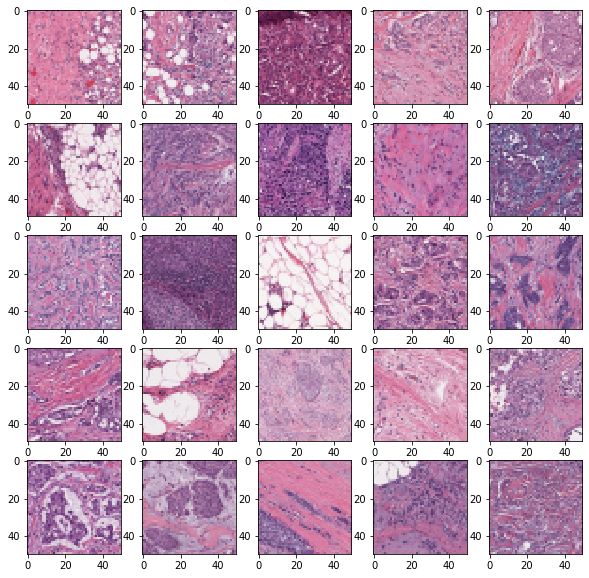

In [ ]:
# Display a grid of random Malignant(Class 1) patches in a matrix of size 5 rows and 5 columns 
n_rows = 5                                                                      # no of patches to be printed in a row
n_cols = 5                                                                      # no of patches to be printed in a column

print('Cancerous Patches')
fig,ax = plt.subplots(n_rows,n_cols,figsize = (10,10))                          #creates a figure(outline)of size 10X10 in order to accomodate 5 images in a row and 5 images in a column

for row in range(n_rows):                                                       #Looping through rows
    for col in range(n_cols):                                                   #Looping through columns
        # below is a counter to cycle through the image indexes
        idx = malignant_positive[col + n_cols*row]                              #storing the index number of the matrix in order to plot the image(Malignant)
        img = io.imread(data_final.loc[idx, "path"])                            #Reads the image and stored in img variable
        ax[row,col].imshow(img[:,:,:])                                          #image is plotted
        ax[row,col].grid(False)

Non-Cancerous Patches


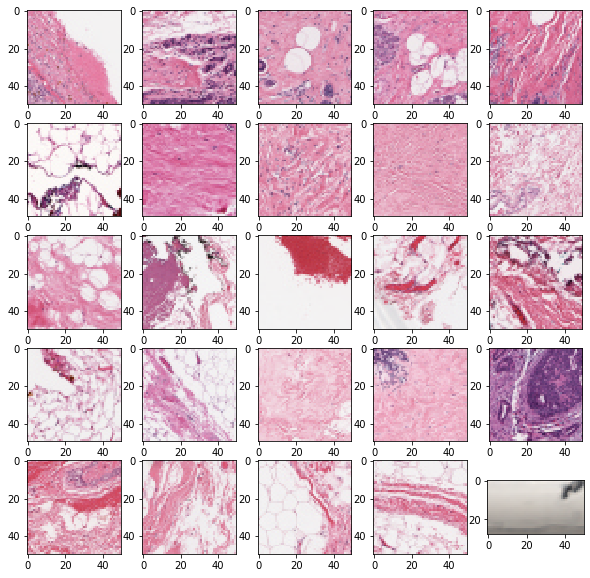

In [ ]:
# Display a grid of random Benign(Class 0) patches in a matrix of size 5 rows and 5 columns 
print('Non-Cancerous Patches')
fig,ax = plt.subplots(n_rows,n_cols,figsize = (10,10))                          #creates a figure(outline)of size 10X10 in order to accomodate 5 images in a row and 5 images in a column
for row in range(n_rows):                                                       #Looping through rows
    for col in range(n_cols):                                                   #Looping through columns
        # below is a counter to cycle through the image indices
        idx = benign_negative[col + n_cols*row]                                 #storing the index number of the matrix in order to plot the image(Malignant)
        img = io.imread(data_final.loc[idx, "path"])                            #Reads the image and stored in img variable
        ax[row,col].imshow(img[:,:,:])                                          #Plot an image 
        ax[row,col].grid(False)

EDA of the dataset : Patientwise

In [ ]:

import matplotlib
sns.set(context='notebook', style='darkgrid', palette='bright', font='sans-serif', font_scale=1, rc=None)    # setting the default configurations of plot with Seaborn sns.set() 
matplotlib.rcParams['figure.figsize'] =[8,8]                                                                 # set the global figure size ( 8 inch height and 8 inch width)for subsequent plots
matplotlib.rcParams.update({'font.size': 15})                                                                # updating the font size for the text in the subsequent plots
matplotlib.rcParams['font.family'] = 'sans-serif'                                                            # Setting the font family as 'sans-serif'
classwise_count_per_patient = data_final.groupby("patient_id").target.value_counts()                         # count the total no of patches for class 0 and class 1 for every patient
print('Classwise proportion of patches per patient')
print(classwise_count_per_patient.head())                                                                    # print first 5 entries 
total_Classcount_per_patient =  data_final.groupby("patient_id").target.size()                               # count the total number of patches(including class 0 and class 1) per patient
print('Total count of patches(including class 0 and class 1) per patient')
print(total_Classcount_per_patient.head())                                                                   # print first 5 entries                
cancer_perc = classwise_count_per_patient / total_Classcount_per_patient                                     # Calculating proportion of class 0 patches (class 0 / class 0 + class 1) and class 1(class 1 / class 0 + class 1) for every patient
cancer_perc = cancer_perc.unstack()                                                                          # Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.
print(cancer_perc.head())                                                                                    # print first 5 entries of the unstacked data ready for analysis

data_final.groupby("patient_id").size()

Classwise proportion of patches per patient
patient_id  target
10253       0         479
            1          70
10254       0         772
            1          76
10255       0         181
Name: target, dtype: int64
Total count of patches(including class 0 and class 1) per patient
patient_id
10253    549
10254    848
10255    272
10256    468
10257    635
Name: target, dtype: int64
target             0         1
patient_id                    
10253       0.872495  0.127505
10254       0.910377  0.089623
10255       0.665441  0.334559
10256       0.750000  0.250000
10257       0.672441  0.327559


patient_id
10253     549
10254     848
10255     272
10256     468
10257     635
         ... 
9346     1361
9347      410
9381     1326
9382     1652
9383      564
Length: 279, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


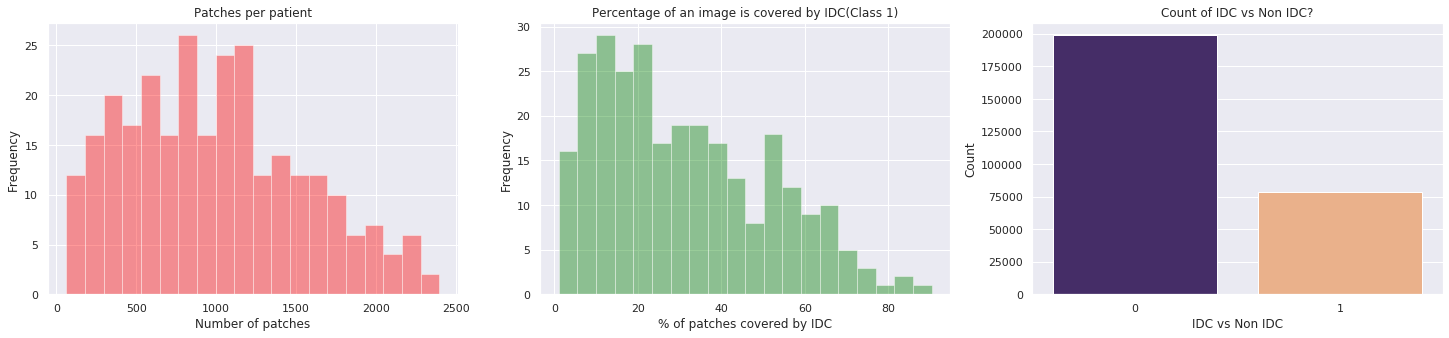

In [ ]:
# 3 different plots
fig, ax = plt.subplots(1,3,figsize=(25,5))                                      # Creates the subplot structure (1 row nd 3 columns) of height 5 inches and widthh 25 inches

# Plotting Frequency of Patches per Patient
sns.distplot(data_final.groupby("patient_id").size(), ax=ax[0], color="red", kde=False, bins=20) # Plots the histogram of Total number of patches. ax[0] signifies that plot will get plotted on the 1st row and 1st column of the subplot
ax[0].set_xlabel("Number of patches")                                           # Sets the approprite label for x axis for the 1st plot
ax[0].set_ylabel("Frequency")                                                   # Sets the approprite label for y axis for the 1st plot
ax[0].set_title("Patches per patient")                                          # Sets the approprite title for the 1st plot

# Plotting Percentage of an image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="green", kde=False, bins=20) # plots the histogram of the total percentage of an image covered by cancer(Maligant). ax[1] signifies that plot will get plotted on the 1st row and 2nd column of the subplot
ax[1].set_title("Percentage of an image is covered by IDC(Class 1)")            # Sets the approprite label for x axis for the 2nd plot
ax[1].set_ylabel("Frequency")                                                   # Sets the approprite label for y axis for the 2nd plot
ax[1].set_xlabel("% of patches covered by IDC")                                 # Sets the approprite title for the 2nd plot


# Plotting number of patches that show IDC
sns.countplot(data_final.target, palette=['#432371',"#FAAE7B"], ax=ax[2]);      # Plots the barplot of the count of class 0 and class 1 patches.ax[1] signifies that plot will get plotted on the 1st row and 3rd column of the subplot
ax[2].set_ylabel("Count")                                                       # Sets the approprite label for x axis for the 3rd plot
ax[2].set_xlabel("IDC vs Non IDC")                                              # Sets the approprite label for y axis for the 3rd plot
ax[2].set_title("Count of IDC vs Non IDC?");                                    # Sets the approprite title for the 3rd plot

**Plot 1 : Patches Per Patient**     
From the plot we can observe that the data of patches per patient is slightly right skewed. The number of patches in the range 0-1200 has the greater frequency and the frequency of patches gets reduces for the number of patches greater than 1500.   
**Plot 2 : Percentage of an image covered by IDC**    
From the plot we can observe that the data of Percentage of patches covered by IDC is slightly right skewed.The plot shows that in majority of the cases, 0-50% area of cancer patches is covered by IDC.    
**Plot 3 : The barplot of IDC vs Non IDC**   
From the barplot, we can say that there are around 1,98,000 patches og class 0(Benign) and around 98000 patches of class 1(Malignant)

In [ ]:
mypaths=[]                                                             # Declaration of a list for storing the path till the patient ids
for name in glob('/content/IDC_regular_ps50_idx5/*',recursive=True):
    mypaths.append(name)
print(mypaths[:5])                                                     # Printing first 5 paths to ensure that it is getting stored correctly

imagePatches =[]                                                       # Declaration of a list for storing the entire path of an individual patch
for i in mypaths:
  imagePatches+=glob(i+'/*/*.png', recursive=True)                     # making sure all the images are of format .png
print(imagePatches[1:5])                                               # imagePAtches variable contains an entire path for all the image patches 
    
print('total no. of images selected from total images is '+str(len(imagePatches)))

['/content/IDC_regular_ps50_idx5/12891', '/content/IDC_regular_ps50_idx5/10276', '/content/IDC_regular_ps50_idx5/14154', '/content/IDC_regular_ps50_idx5/14192', '/content/IDC_regular_ps50_idx5/15512']
['/content/IDC_regular_ps50_idx5/12891/1/12891_idx5_x1701_y1651_class1.png', '/content/IDC_regular_ps50_idx5/12891/1/12891_idx5_x2051_y1051_class1.png', '/content/IDC_regular_ps50_idx5/12891/1/12891_idx5_x1651_y1401_class1.png', '/content/IDC_regular_ps50_idx5/12891/1/12891_idx5_x1451_y1151_class1.png']
total no. of images selected from total images is 277524


In [ ]:
class_0_path = []                                                               # creation of a variable to store all the class 0 (Benign) images along with their entire path
class_1_path = []                                                               # creation of a variable to store all the class 1 (Malignant) images along with their entire path

# for loop for segregating beign and malignant image paths
for filename in imagePatches[0:30000]:                                          # Due to computation limitation , we will use 30,000 patches for our model
    if filename.endswith("class0.png"):
         class_0_path.append(filename)                                          # appending all the patches belonging to class 0 into variable class_0_path
    else:
        class_1_path.append(filename)                                           # appending all the patches belonging to class 1 into variable class_1_path

print('The entire dataset is divided into '+str(len(class_0_path))+' patches of class0(Benign) and '+str(len(class_1_path))+' patches of class1(Malignant).')


The entire dataset is divided into 20753 patches of class0(Benign) and 9247 patches of class1(Malignant).


# Data Preprocessing

In [ ]:
# Coverting an image into an array
def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):                                                                # for loop works if only the image extension is .png
            img = cv2.imread(i ,cv2.IMREAD_COLOR)                                             # loads a color image from the specified file
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_CUBIC)              # changing the dimension of the images to 50*50 along with INTER_AREA interpolation which helps in image decimation
            img_re=img_sized/255.0                                                            # The images are first normalized by dividing it by 255. This ensures that all the values are between 0 and 1.
            img_arrays.append([img_re, label])                                                #This ensures that all the values are between 0 and 1. This helps us to train the model faster and also prevents us from falling into the vanishing and exploding gradients problem.
    return img_arrays

In [ ]:
# Converting images of class 0 and class 1 into an array
class0_array = get_image_arrays(class_0_path, 0)    # retrieve array of class 0 patches
class1_array = get_image_arrays(class_1_path, 1)    # retrieve array of class 1 patches

print('Total number of patches are : {} '.format(len(class0_array) + len(class1_array)))
print('Total number of Non-IDC(Benign) patches are : {} '.format(len(class0_array)))
print('Total number of IDC(Malignant) patches are : {} '.format(len(class1_array)))
#print('Every Patch has a shape of (Width, Height, Channels): {}'.format(class0_array[1].shape))

Total number of patches are : 30000 
Total number of Non-IDC(Benign) patches are : 20753 
Total number of IDC(Malignant) patches are : 9247 


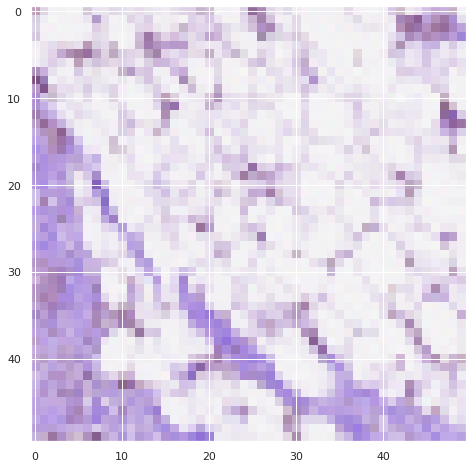

In [ ]:
# Randomly print any image from class 1
plt.imshow(class1_array[10][0])

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))                        # combining data of both IDC and Non IDC pathces

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X = []                                                                # Declaration of X for saving all the features data into it
Y = []                                                                # Declaration of Y for saving all the labels data into it

# For loop for separation of features and labels
for features,label in combined_data:
    X.append(features)                                                # X holds the features
    Y.append(label)                                                   # Y holds the labels : Benign and Malignant ( target variable that needs to classify ) 
#np.shape(X)
X = np.array(X)                                                       # Since X contains multidimensional array, first converting it numpy array
Y = pd.Series(Y)                                                      # Converting Y into pandas series 

# Data train and Test split

In [ ]:
# The X and Y data is then splitted to train and test data, with 20% of the entire dataset reserved for testing. 
# train_test_split function Splits the arrays or matrices into random train and test subsets.

                                                                                                 # X is an array of features where y is a vector of the labels of class 0 and class 1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20200315)  # test_size = 0.2 makes sure that the data is divided into 80% training set and 20% test set
                                                                                                 # random_state = 20200315  produces the same result across a different run.
                                                                                  

One hot encoding


In [ ]:
# to_categorical(), a numpy array (or) a vector which has integers that represent different categories,
# can be converted into a numpy array (or) a matrix which has binary values and has columns equal to the number of categories in the data
Y_train = to_categorical(Y_train, num_classes=2)           # one-hot encoding of Y_train variable
Y_test = to_categorical(Y_test, num_classes=2)             # one-hot encoding of Y_test variable
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(24000, 50, 50, 3) (6000, 50, 50, 3) (24000, 2) (6000, 2)


In [ ]:
print('Shape of Training data for features is : {} '.format(X_train.shape))
print('Shape of Testing data for features is : {} '.format(X_test.shape))
print('Shape of Training data for labels is : {} '.format(Y_train.shape))
print('Shape of Testing data for labels is : {} '.format(Y_test.shape))

Shape of Training data for features is : (24000, 50, 50, 3) 
Shape of Testing data for features is : (6000, 50, 50, 3) 
Shape of Training data for labels is : (24000, 2) 
Shape of Testing data for labels is : (6000, 2) 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


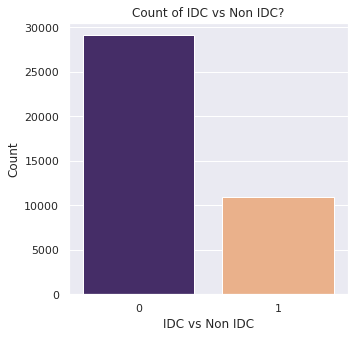

In [ ]:
# Since the no of patches that we are using is reduced to 30000, this the new count plot
fig= plt.subplots(figsize=(5,5))    
a = sns.countplot(data_final[0:40000].target, palette=['#432371',"#FAAE7B"]);
a.set_ylabel("Count")
a.set_xlabel("IDC vs Non IDC")
a.set_title("Count of IDC vs Non IDC?");

# Hyperparameter and Data Augmentation

In [ ]:
num_classes = 2                                                                           # Since we have 2 classes to predict as our output, we set num_classes as 2
img_rows,img_cols=50,50                                                                   # The input patch images is 50*50 in size
BATCH_SIZE = 128                                                                          # the number of training examples in one forward/backward pass. 
# Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and stop training once the model performance stops improving on the validation dataset.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='auto') # monitor : Here we want val_loss to be monitored(to be least)
                                                                                          # min_delta : Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
                                                                                          # patience : Number of epochs with no improvement after which training will be stopped
                                                                                          # mode : auto : in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
# This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
learn_control = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1, mode='min') # monitor : Here we want val_loss to be monitored(to be least)
                                                                                           # factor : factor by which the learning rate will be reduced. new_lr = lr * factor. 
                                                                                           # patience : number of epochs with no improvement after which learning rate will be reduced.
                                                                                           # verbose : int. 0: quiet, 1: update messages.
                                                                                           # mode : In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing;
                                                                                           # min_lr : lower bound on the learning rate


Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=True,                                                    # set input mean to 0 over the dataset
    featurewise_std_normalization=True,                                         # divide inputs by std of the dataset
    rotation_range=180,                                                         # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,                                                      # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,                                                     # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,                                                       # randomly flip images horizontally
    vertical_flip = True,                                                       # randomly flip images vertically
    fill_mode='reflect')                                                        # Points outside the boundaries of the input are filled according to the given mode:'reflect': abcddcba|abcd|dcbaabcd


# Model 1 : CNN1

Model 1 : Architecture of CNN1

1. The basline fundamental CNN architecture has 4 layers with 3 levels of convolution With 32, 64, 64 filters in the convolution layers and a final Fully Connected Layer with 81 neurons. 
2. The CNN1 model consists of this baseline 4 layer CNN alongwith one extra convolution layer of 128 filters.
3. This first convolutional layer consists of 32 filters with the kernel size of 5X5 and the input is given as image height and width(50X50), followed by a pooling layer with window size of 5X5. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
4. The second convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
5. The Third convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation function used is 'ReLU'.
6. The fourth convolution layer consists of 128 filters with the kernel size of 3X3. The activation function used is 'ReLU'.
7. The data is then flattened( converted into 1 dimension) to fed to the dense layer. The last dense laayer consists of 81 neurons along the 'ReLU' activation function.
8. The final dense layer has 2 neurons as this is a binary classification problem along with 'SoftMax' activation function.
9. model.compile() is used to compile the defined architecture



In [ ]:
##########################################
#                MODEL 1  : CNN1         #
##########################################
# keras Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
model1 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(5,5),activation='relu', input_shape=(img_rows,img_cols,3), padding="same"),
    keras.layers.MaxPool2D(pool_size=(5,5)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.Flatten(),
    keras.layers.Dense(81,activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model1.compile(
    optimizer=tf.optimizers.Adam(lr=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model1.summary()                                                                # Provides the summary of a defined model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model 1 Fitting

Model training : 
1. Here we are training our network for 10 epochs along with the training data X_Train and Y_Train with batch size of 128.
2. steps_per_epoch :  It specifies the total number of steps taken from the generator as soon as one epoch is finished and next epoch has started. We can calculate the value of steps_per_epoch as the total number of samples in your dataset divided by the batch size.
3. epochs : an integer and number of epochs we want to train our model for( in our case it is 100)
4. validation data :  It is nothing but the test data
5. callbacks : a list of callback functions applied during the training of our model.(in our case, we are going to apply earlystopping and ReduceLROnplateau callbacks)

In [ ]:
# Defining Model Fitting Start Time
training_start_time = process_time()

#Because we are using ImageDataGenerator , we use model.fit_generator to train the model.
history_model1 = model1.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,                              
    epochs=100,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop , learn_control]
)

# Defining Model Fitting End Time
training_end_time = process_time()

# Finding Total Time taken for Model Fitting
training_total_time = training_end_time - training_start_time                                                    

# Printing Total Time taken for Model Fitting
print("Total time taken for Model1 Fitting: ",training_total_time," seconds")         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
187/187 [==============================] - 52s 110ms/step - loss: 0.6458 - accuracy: 0.6726 - val_loss: 0.6615 - val_accuracy: 0.6925
Epoch 2/100
187/187 [==============================] - 19s 99ms/step - loss: 0.5147 - accuracy: 0.7802 - val_loss: 0.5970 - val_accuracy: 0.7887
Epoch 3/100
187/187 [==============================] - 19s 99ms/step - loss: 0.4497 - accuracy: 0.8011 - val_loss: 0.4946 - val_accuracy: 0.8018
Epoch 4/100
187/187 [==============================] - 20s 107ms/step - loss: 0.4214 - accuracy: 0.8117 - val_loss: 0.4318 - val_accuracy: 0.8185
Epoch 5/100
187/187 [==============================] - 19s 102ms/step - loss: 0.4052 - accuracy: 0.8195 - val_loss: 0.4112 - val_accuracy: 0.8235
Epoch 6/100
187/187 [==============================] - 18s 98ms/step - loss: 0.3955 - accuracy: 0.8228 - val_loss: 0.3889 - val_accuracy: 0.8287
Epoch 7/100
187/187 [==============================] - 19s 101ms/step - loss: 0.3888 - accuracy: 0.8259 - val_loss: 0.3858 - va

Prediction of Test label(Y) dataset

In [ ]:

y_pred_one_hot_CNN1 = model1.predict(X_test)                                         # prediction of benign and malignant classes of the test data using the best model

# Predicted classified data for benign and malignant images
y_pred_labels_CNN1 = np.argmax(y_pred_one_hot_CNN1, axis = 1)                         # numpy.argmax() function returns indices of the max element of the array in a particular axis. 
                                                                                      # y_pred_labels_CNN1 holds the predicted classfied label data for Benign and Malignant patches

# Original classified data fro benign and malignant images                   
y_true_labels_CNN1 = np.argmax(Y_test,axis=1)                                         # y_true_labels_CNN1 holds the original classfied label data for Benign and Malignant patches
 

Accuracy and Loss plot : CNN1

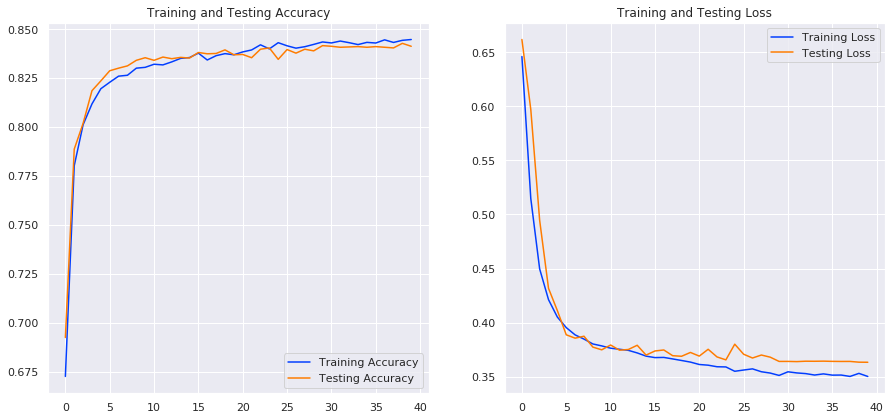

In [ ]:
# Extracting accurcy, val_accuracy ,loss and val_loss in 4 different variables
acc = history_model1.history['accuracy']                               # Retrieves the accuracy values for training data that model achieved while training
val_acc = history_model1.history['val_accuracy']                       # Retrieves the accuracy values for testing data that model achieved while training
loss = history_model1.history['loss']                                  # Retrieves the loss values for training data that model achieved while training
val_loss = history_model1.history['val_loss']                          # Retrieves the loss values for testing data that model achieved while training


# Accuracy plot
plt.figure(figsize=(15, 15))                                          # Creation of a plot having height and width of 15 inches
plt.subplot(2, 2, 1)                                                  # creates subplot and selects 1st subplot among two for further plotting
plt.plot( acc, label='Training Accuracy')                             # plotting accuracy values for training data
plt.plot( val_acc, label='Testing Accuracy')                          # plotting accuracy values for testing data
plt.legend(loc='lower right')                                         # plotting the legend in the lower right corner
plt.title('Training and Testing Accuracy')                            # provide appropriate title to the Accuracy plot

# Loss plot
plt.subplot(2, 2, 2)                                                 # creates subplot and selects 2nd subplot among two for further plotting
plt.plot(loss, label='Training Loss')                                # plotting loss values for training data
plt.plot(val_loss, label='Testing Loss')                             # plotting loss values for testing data
plt.legend(loc='upper right')                                        # plotting the legend in the lower right corner
plt.title('Training and Testing Loss')                               # provide appropriate title to the loss plot
plt.show()                                                           # Display the plot


Evaluation metric fr CNN1 : Confusion matrix

Confusion Matrix


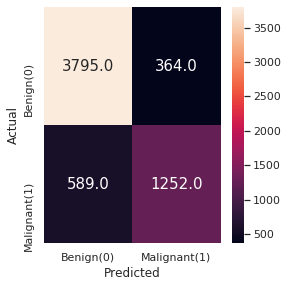

In [ ]:
confusion_matrix_CNN1 = metrics.confusion_matrix(y_true=y_true_labels_CNN1, y_pred=y_pred_labels_CNN1)  #Compute confusion matrix to evaluate the accuracy of a classification.
print('Confusion Matrix')
classes=['Benign(0)','Malignant(1)']                                  # Creation of a class in order to use it as a label in a confusion matrix
con_mat_df_CNN1 = pd.DataFrame(confusion_matrix_CNN1,                 # converting the confusion matrix into dataframe to plot a heatmap
                     index = classes, 
                     columns = classes)

# Printing confustion matrix in a table format
figure = plt.figure(figsize=(4,4))                                    # Creates a plot of height and width of 4 inches
sns.heatmap(con_mat_df_CNN1, annot=True, fmt='.1f')                   # Plots rectangular data as a color-encoded matrix. annot = True helps to write the data value in each cell.
plt.tight_layout()                                                    # fmt='.1f' change the format of the annotation from the default scientific notation to one decimal precision
plt.ylabel('Actual')                                                  # provides appropriate label to Y axis
plt.xlabel('Predicted')                                               # provides appropriate label to Y axis
plt.show()                                                            # displays a plot


Evaluation metric fr CNN1 : Classification Report

In [ ]:
print('Classification Report')
# Builds a text report showing the main classification metrics.
print(classification_report(y_true_labels_CNN1, y_pred_labels_CNN1, target_names=['Negative(Benign)','Positive(Malignant)']))


Classification Report
                     precision    recall  f1-score   support

   Negative(Benign)       0.87      0.91      0.89      4159
Positive(Malignant)       0.77      0.68      0.72      1841

           accuracy                           0.84      6000
          macro avg       0.82      0.80      0.81      6000
       weighted avg       0.84      0.84      0.84      6000



In [ ]:

model1.save("model1.h5")      
print("Model 1 is saved to disk")

Model 1 is saved to disk


# Model 2 : CNN2

Model 1 : Architecture of CNN2

1. The basline fundamental CNN architecture has 4 layers with 3 levels of convolution With 32, 64, 64 filters in the convolution layers and a final Fully Connected Layer with 81 neurons. 
2. The CNN2 model consists of this baseline 4 layer CNN alongwith one extra convolution layer of 128 filters and a dropout layer.
3. This first convolutional layer consists of 32 filters with the kernel size of 5X5 and the input is given as image height and width(50X50), followed by a pooling layer with window size of 5X5. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
4. The second convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
5. The Third convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation function used is 'ReLU'.
6. The fourth convolution layer consists of 128 filters with the kernel size of 3X3, followed by a dropout layer with value as 0.5 meaning half of the neurons will stop working. The activation function used is 'ReLU'.
7. The data is then flattened( converted into 1 dimension) to fed to the dense layer. The last dense laayer consists of 81 neurons along the 'ReLU' activation function.
8. The final dense layer has 2 neurons as this is a binary classification problem along with 'SoftMax' activation function.
9. model.compile() is used to compile the defined architecture



In [ ]:
##########################################
#                MODEL 2                 #
##########################################

model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(5,5),activation='relu', input_shape=(img_rows,img_cols,3), padding="same"),
    keras.layers.MaxPool2D(pool_size=(5,5)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.Dense(81,activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model2.compile(
    optimizer=tf.optimizers.Adam(lr=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model2.summary()                                                                # provides the model summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 3, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Fitting model 2 : CNN2

Model training : 
1. Here we are training our network for 10 epochs along with the training data X_Train and Y_Train with batch size of 128.
2. steps_per_epoch :  It specifies the total number of steps taken from the generator as soon as one epoch is finished and next epoch has started. We can calculate the value of steps_per_epoch as the total number of samples in your dataset divided by the batch size.
3. epochs : an integer and number of epochs we want to train our model for( in our case it is 100)
4. validation data :  It is nothing but the test data
5. callbacks : a list of callback functions applied during the training of our model.(in our case, we are going to apply earlystopping and ReduceLROnplateau callbacks)

In [ ]:
# Defining Model Fitting Start Time
training_start_time = process_time()

history_model2 = model2.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop , learn_control]
)

# Defining Model Fitting End Time
training_end_time = process_time()

# Finding Total Time taken for Model Fitting
training_total_time = training_end_time - training_start_time                                                    

# Printing Total Time taken for Model Fitting
print("Total time taken for Model1 Fitting: ",training_total_time," seconds") 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
187/187 [==============================] - 20s 103ms/step - loss: 0.6395 - accuracy: 0.6873 - val_loss: 0.6459 - val_accuracy: 0.6932
Epoch 2/100
187/187 [==============================] - 20s 108ms/step - loss: 0.5378 - accuracy: 0.7072 - val_loss: 0.5651 - val_accuracy: 0.6925
Epoch 3/100
187/187 [==============================] - 18s 97ms/step - loss: 0.4981 - accuracy: 0.7510 - val_loss: 0.4940 - val_accuracy: 0.7462
Epoch 4/100
187/187 [==============================] - 18s 95ms/step - loss: 0.4742 - accuracy: 0.7874 - val_loss: 0.4604 - val_accuracy: 0.7838
Epoch 5/100
187/187 [==============================] - 20s 107ms/step - loss: 0.4541 - accuracy: 0.8021 - val_loss: 0.4476 - val_accuracy: 0.7977
Epoch 6/100
187/187 [==============================] - 20s 104ms/step - loss: 0.4376 - accuracy: 0.8109 - val_loss: 0.4388 - val_accuracy: 0.8070
Epoch 7/100
187/187 [==============================] - 18s 96ms/step - loss: 0.4235 - accuracy: 0.8192 - val_loss: 0.4123 - va

Prediction of test label(Y) dataset

In [ ]:
y_pred_one_hot_CNN2 = model2.predict(X_test)                                                 # prediction of benign and malignant classes of the test data using the best model

# Predicted classified data for benign and malignant images
y_pred_labels_CNN2 = np.argmax(y_pred_one_hot_CNN2, axis = 1)                                # numpy.argmax() function returns indices of the max element of the array in a particular axis.  
                                                                                             # y_pred_labels_CNN2 holds the predicted classfied label data for Benign and Malignant patches
# Original classified data for benign and malignant images#                    
y_true_labels_CNN2 = np.argmax(Y_test,axis=1)                                                # y_true_labels_CNN2 holds the Actual label data for Benign and Malignant patches


Accuracy and Loss plots : CNN2


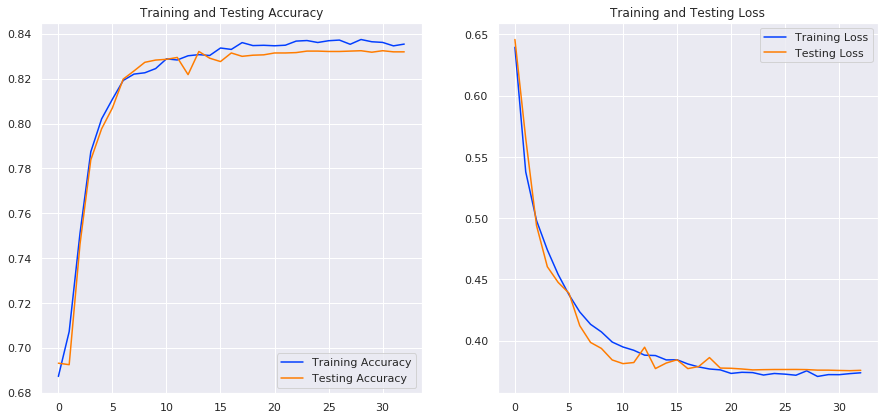

In [ ]:
acc = history_model2.history['accuracy']                               # Retrieves the accuracy values for training data that model achieved while training
val_acc = history_model2.history['val_accuracy']                       # Retrieves the accuracy values for testing data that model achieved while training
loss = history_model2.history['loss']                                  # Retrieves the loss values for training data that model achieved while training
val_loss = history_model2.history['val_loss']                          # Retrieves the loss values for testing data that model achieved while training


# Accuracy plot
plt.figure(figsize=(15, 15))                                          # Creation of a plot having height and width of 15 inches
plt.subplot(2, 2, 1)                                                  # creates subplot and selects 1st subplot among two for further plotting
plt.plot( acc, label='Training Accuracy')                             # plotting accuracy values for training data
plt.plot( val_acc, label='Testing Accuracy')                          # plotting accuracy values for testing data
plt.legend(loc='lower right')                                         # plotting the legend in the lower right corner
plt.title('Training and Testing Accuracy')                            # provide appropriate title to the Accuracy plot

# Loss plot
plt.subplot(2, 2, 2)                                                 # creates subplot and selects 2nd subplot among two for further plotting
plt.plot(loss, label='Training Loss')                                # plotting loss values for training data
plt.plot(val_loss, label='Testing Loss')                             # plotting loss values for testing data
plt.legend(loc='upper right')                                        # plotting the legend in the lower right corner
plt.title('Training and Testing Loss')                               # provide appropriate title to the loss plot
plt.show()                                                           # Display the plot

Evaluation Metric for CNN2 : Confusion matrix

Confusion Matrix


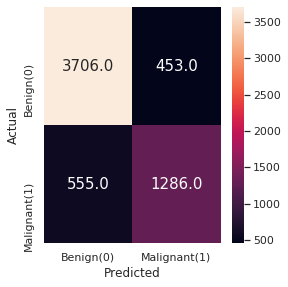

In [ ]:
confusion_matrix_CNN2 = metrics.confusion_matrix(y_true=y_true_labels_CNN2, y_pred=y_pred_labels_CNN2)  #Compute confusion matrix to evaluate the accuracy of a classification.
print('Confusion Matrix')
classes=['Benign(0)','Malignant(1)']                                  # Creation of a class in order to use it as a label in a confusion matrix
con_mat_df_CNN2 = pd.DataFrame(confusion_matrix_CNN2,                 # converting the comfusion matrox into dataframe to plot a heatmap
                     index = classes, 
                     columns = classes)

# Printing confustion matrix in a table format
figure = plt.figure(figsize=(4,4))                                    # Creates a plot of height and width of 4 inches
sns.heatmap(con_mat_df_CNN2, annot=True, fmt='.1f')                   # Plots rectangular data as a color-encoded matrix. annot = True helps to write the data value in each cell.
plt.tight_layout()                                                    # fmt='.1f' change the format of the annotation from the default scientific notation to one decimal precision
plt.ylabel('Actual')                                                  # provides appropriate label to Y axis
plt.xlabel('Predicted')                                               # provides appropriate label to Y axis
plt.show()                                                            # displays a plot


Evaluation Metric for CNN2 : Claasification Report

In [ ]:
print('Classification Report')
# Builds a text report showing the main classification metrics.
print(classification_report(y_true_labels_CNN2, y_pred_labels_CNN2, target_names=['Negative(Benign)','Positive(Malignant)']))


Classification Report
                     precision    recall  f1-score   support

   Negative(Benign)       0.87      0.89      0.88      4159
Positive(Malignant)       0.74      0.70      0.72      1841

           accuracy                           0.83      6000
          macro avg       0.80      0.79      0.80      6000
       weighted avg       0.83      0.83      0.83      6000



In [ ]:
model2.save("model1.h5")
print("Model 2 is saved to disk")

Model 2 is saved to disk


# Model 3 : CNN3

Model 3 : Architecture of CNN3

1. The basline fundamental CNN architecture has 4 layers with 3 levels of convolution With 32, 64, 64 filters in the convolution layers and a final Fully Connected Layer with 81 neurons. 
2. The CNN2 model consists of this baseline 4 layer CNN alongwith one extra convolution layer of 128 filters and a dropout layer.
3. This first convolutional layer consists of 32 filters with the kernel size of 5X5 and the input is given as image height and width(50X50), followed by a pooling layer with window size of 5X5. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
4. The second convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation functionis used is 'ReLU' and also batchNormalization is used for standardizing inputs and outputs.
5. The Third convolution layer consists of 64 filters with the kernel size of 3X3, followed by a pooling layer with window size of 3X3. The activation function used is 'ReLU'.
6. The fourth convolution layer consists of 128 filters with the kernel size of 3X3, followed by a dropout layer with value as 0.5 meaning half of the neurons will stop working. The activation function used is 'ReLU'.
7. The next dense layer has 144 neurons along with 'ReLU' activation function, followed by a dropout layer with 50% rate of shutting down of neurons.
8. The data is then flattened( converted into 1 dimension) to fed to the dense layer. The last dense laayer consists of 81 neurons along the 'ReLU' activation function.
9. The final dense layer has 2 neurons as this is a binary classification problem along with 'SoftMax' activation function.
10. model.compile() is used to compile the defined architecture



In [ ]:
##########################################
#                MODEL 3                 #
##########################################

model3 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(5,5),activation='relu', input_shape=(img_rows,img_cols,3), padding="same"),
    keras.layers.MaxPool2D(pool_size=(5,5)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation='relu', padding="same"),
    keras.layers.Dropout(0.50),
    keras.layers.Dense(144,activation='relu'),
    keras.layers.Dropout(0.50),
    keras.layers.Flatten(),
    keras.layers.Dense(81,activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model3.compile(
    optimizer=tf.optimizers.Adam(lr=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


model3.summary()              

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 50, 50, 32)        2432      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 64)          256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model 3 Fitting

Model training : 
1. Here we are training our network for 10 epochs along with the training data X_Train and Y_Train with batch size of 128.
2. steps_per_epoch :  It specifies the total number of steps taken from the generator as soon as one epoch is finished and next epoch has started. We can calculate the value of steps_per_epoch as the total number of samples in your dataset divided by the batch size.
3. epochs : an integer and number of epochs we want to train our model for( in our case it is 100)
4. validation data :  It is nothing but the test data
5. callbacks : a list of callback functions applied during the training of our model.(in our case, we are going to apply earlystopping and ReduceLROnplateau callbacks)

In [ ]:
# Defining Model Fitting Start Time
training_start_time = process_time()

history_model3 = model3.fit_generator(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop , learn_control]
)

# Defining Model Fitting End Time
training_end_time = process_time()

# Finding Total Time taken for Model Fitting
training_total_time = training_end_time - training_start_time                                                    

# Printing Total Time taken for Model Fitting
print("Total time taken for Model1 Fitting: ",training_total_time," seconds") 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
187/187 [==============================] - 19s 99ms/step - loss: 0.6593 - accuracy: 0.6210 - val_loss: 0.6520 - val_accuracy: 0.6932
Epoch 2/100
187/187 [==============================] - 18s 98ms/step - loss: 0.5788 - accuracy: 0.7004 - val_loss: 0.5733 - val_accuracy: 0.6930
Epoch 3/100
187/187 [==============================] - 21s 109ms/step - loss: 0.5339 - accuracy: 0.7130 - val_loss: 0.5085 - val_accuracy: 0.7202
Epoch 4/100
187/187 [==============================] - 19s 103ms/step - loss: 0.5091 - accuracy: 0.7328 - val_loss: 0.4781 - val_accuracy: 0.7678
Epoch 5/100
187/187 [==============================] - 18s 97ms/step - loss: 0.4878 - accuracy: 0.7625 - val_loss: 0.4537 - val_accuracy: 0.7962
Epoch 6/100
187/187 [==============================] - 19s 103ms/step - loss: 0.4704 - accuracy: 0.7880 - val_loss: 0.4370 - val_accuracy: 0.8063
Epoch 7/100
187/187 [==============================] - 20s 107ms/step - loss: 0.4545 - accuracy: 0.8020 - val_loss: 0.4246 - va

Prediction of the test label (Y) dataset


In [ ]:
y_pred_one_hot_CNN3 = model3.predict(X_test)                                                # prediction of benign and malignant classes of the test data using the best model

# Predicted classified data for benign and malignant images
y_pred_labels_CNN3 = np.argmax(y_pred_one_hot_CNN3, axis = 1)                               # numpy.argmax() function returns indices of the max element of the array in a particular axis. 
                                                                                            # y_pred_labels_CNN2 holds the predicted classfied label data for Benign and Malignant patches

# Original classified data fro benign and malignant images#                    
y_true_labels_CNN3 = np.argmax(Y_test,axis=1)                                              # y_true_labels_CNN1 holds the original classfied label data for Benign and Malignant patches


Accuracy and Loss plots : CNN3

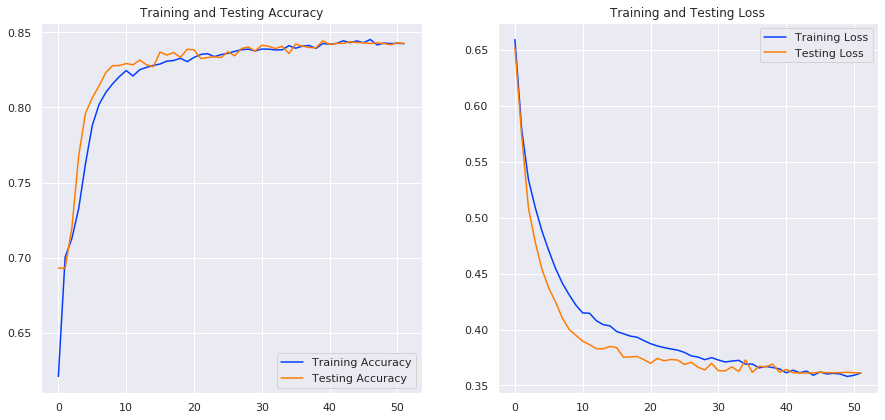

In [ ]:
# Extracting accurcy, val_accuracy ,loss and val_loss in 4 different variables
acc = history_model3.history['accuracy']                               # Retrieves the accuracy values for training data that model achieved while training
val_acc = history_model3.history['val_accuracy']                       # Retrieves the accuracy values for testing data that model achieved while training
loss = history_model3.history['loss']                                  # Retrieves the loss values for training data that model achieved while training
val_loss = history_model3.history['val_loss']                          # Retrieves the loss values for testing data that model achieved while training


# Accuracy plot
plt.figure(figsize=(15, 15))                                          # Creation of a plot having height and width of 15 inches
plt.subplot(2, 2, 1)                                                  # creates subplot and selects 1st subplot among two for further plotting
plt.plot( acc, label='Training Accuracy')                             # plotting accuracy values for training data
plt.plot( val_acc, label='Testing Accuracy')                          # plotting accuracy values for testing data
plt.legend(loc='lower right')                                         # plotting the legend in the lower right corner
plt.title('Training and Testing Accuracy')                            # provide appropriate title to the Accuracy plot

# Loss plot
plt.subplot(2, 2, 2)                                                 # creates subplot and selects 2nd subplot among two for further plotting
plt.plot(loss, label='Training Loss')                                # plotting loss values for training data
plt.plot(val_loss, label='Testing Loss')                             # plotting loss values for testing data
plt.legend(loc='upper right')                                        # plotting the legend in the upper right corner
plt.title('Training and Testing Loss')                               # provide appropriate title to the loss plot
plt.show()                                                           # Display the plot

Evaluation metric for CNN3 : Confusion Matrix

Confusion Matrix


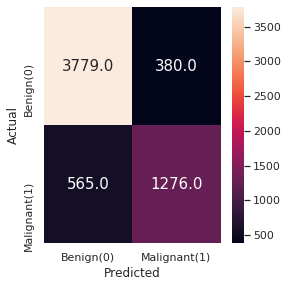

In [ ]:
confusion_matrix_CNN3 = metrics.confusion_matrix(y_true=y_true_labels_CNN3, y_pred=y_pred_labels_CNN3)  #Compute confusion matrix to evaluate the accuracy of a classification.
print('Confusion Matrix')
classes=['Benign(0)','Malignant(1)']                                  # Creation of a class in order to use it as a label in a confusion matrix
con_mat_df_CNN3 = pd.DataFrame(confusion_matrix_CNN3,                 # converting the comfusion matrox into dataframe to plot a heatmap
                     index = classes, 
                     columns = classes)

# Printing confustion matrix in a table format
figure = plt.figure(figsize=(4,4))                                    # Creates a plot of height and width of 4 inches
sns.heatmap(con_mat_df_CNN3, annot=True, fmt='.1f')                   # Plots rectangular data as a color-encoded matrix. annot = True helps to write the data value in each cell.
plt.tight_layout()                                                    # fmt='.1f' change the format of the annotation from the default scientific notation to one decimal precision
plt.ylabel('Actual')                                                  # provides appropriate label to Y axis
plt.xlabel('Predicted')                                               # provides appropriate label to Y axis
plt.show()                                                            # displays a plot



Evaluation metric for CNN3 : Classification Report

In [ ]:
print('Classification Report')
# Builds a text report showing the main classification metrics.
print(classification_report(y_true_labels_CNN3, y_pred_labels_CNN3, target_names=['Negative(Benign)','Positive(Malignant)']))


Classification Report
                     precision    recall  f1-score   support

   Negative(Benign)       0.87      0.91      0.89      4159
Positive(Malignant)       0.77      0.69      0.73      1841

           accuracy                           0.84      6000
          macro avg       0.82      0.80      0.81      6000
       weighted avg       0.84      0.84      0.84      6000



Evaluation metric for CNN3 : ROC and AUC

In [ ]:
# Defining End Run Time
end_time = process_time()

# Total Run Time
total_time = end_time - start_time
print("Total Execution Time Taken: ",total_time," seconds")

Total Execution Time Taken:  2679.157216617  seconds


In [ ]:
model3.save('model3.h5')
print('Model 3 is saved to disk')

Model 3 is saved to disk


# Performance Analysis of Three models


Function that creates plot of various evaluation metrics for three different models

In [ ]:
#DEFINING DATAFRAME FOR COLLECTING THE RESULTS OF EACH MODEL FOR EAVALUATION AND COMPARISON PURPOSE.
MODEL_PERFROMANCE_DF = pd.DataFrame(columns=['MODEL_NAME','PRECISION','RECALL','F1_SCORE','AUC_SCORE','FP_RATE','TP_RATE'])

def get_model_performance_parameters(true_variable, pred_variable ,model_name):
  
  #DEFINING MODEL_PERFROMANCE_DF AS GLOBAL VARIABLE. 
  global MODEL_PERFROMANCE_DF
  #GETTING MODEL SCORES
  FP_RATE,TP_RATE,_ = metrics.roc_curve(true_variable,  pred_variable)          # retrieving fp_rate and tp_rate score for plotting roc curve
  AUC_SCORE= metrics.roc_auc_score(true_variable, pred_variable[:])             # retrieving auc_score values
  F1_SCORE= metrics.f1_score(true_variable, pred_variable)                      # retrieving F1 score values
  PRECISION= metrics.precision_score(true_variable, pred_variable)              # retrieving Precision values
  RECALL= metrics.recall_score(true_variable, pred_variable)                    #retrieving recall values
  ACCURACY = metrics.accuracy_score(true_variable,pred_variable)                # retrieving accuracy values
  MODEL_NAME = model_name                                                       # storing model name
 


  #COLLECTING MODEL PERFORMANCE VALUES.
  MODEL_PERFROMANCE_DF=MODEL_PERFROMANCE_DF.append({'MODEL_NAME':MODEL_NAME,'PRECISION':PRECISION,'RECALL':RECALL,'F1_SCORE':F1_SCORE, 
                                                    'FP_RATE':FP_RATE, 'TP_RATE':TP_RATE, 'AUC_SCORE':AUC_SCORE,'ACCURACY':ACCURACY}, ignore_index=True)

  print(model_name +" parameters recorded")

Calling function 'get_model_performance_parameters' for three models

In [ ]:
# Model 1 : CNN1
get_model_performance_parameters(y_true_labels_CNN1,y_pred_labels_CNN1,'CNN1')  # above function is applied on model 1 : CNN1 to add the evaluation metric parameters in the dataframe
# Model 2 : CNN2
get_model_performance_parameters(y_true_labels_CNN2,y_pred_labels_CNN2,'CNN2')  # above function is applied on model 2 : CNN2 to append the evaluation metric parameters in the dataframe
# Model 3 : CNN3
get_model_performance_parameters(y_true_labels_CNN3,y_pred_labels_CNN3,'CNN3')  # above function is applied on model 3 : CNN3 to append the evaluation metric parameters in the dataframe

CNN1 parameters recorded
CNN2 parameters recorded
CNN3 parameters recorded


Text(0, 0.5, 'SCORE VALUES [0--1]')

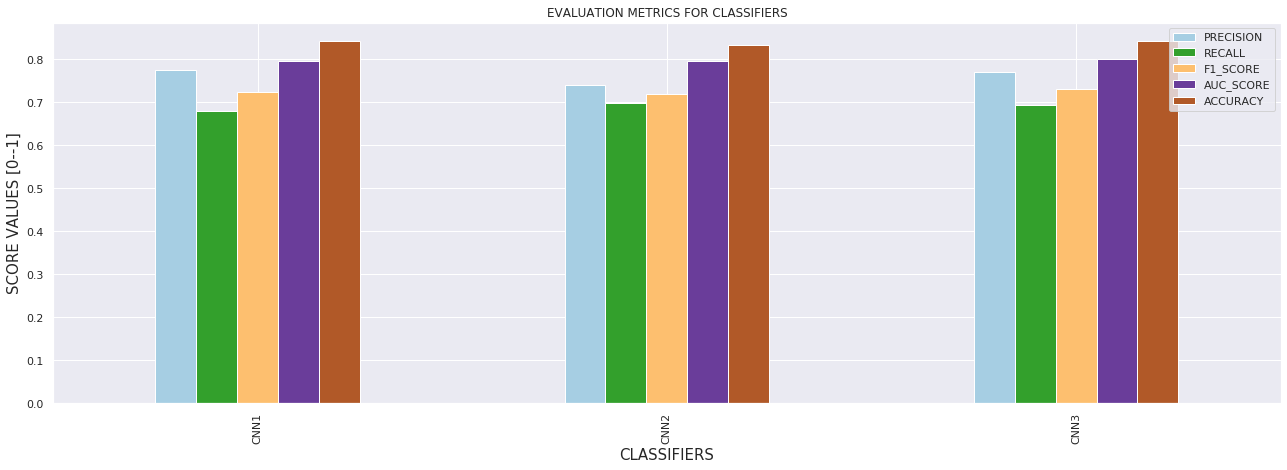

In [ ]:
# evaluation metrics plot for comparison. 
ax = MODEL_PERFROMANCE_DF.plot(x='MODEL_NAME',kind='bar',stacked=False,title='EVALUATION METRICS FOR CLASSIFIERS',figsize=(22,7),colormap='Paired')
ax.set_xlabel("CLASSIFIERS",fontsize = 15)
ax.set_ylabel("SCORE VALUES [0--1]",fontsize = 15)

In [ ]:
# Checking the dataframe of the stored result
MODEL_PERFROMANCE_DF

,MODEL_NAME,PRECISION,RECALL,F1_SCORE,AUC_SCORE,FP_RATE,TP_RATE,ACCURACY
0,CNN1,0.774752,0.680065,0.724327,0.796272,"[0.0, 0.08752103871122865, 1.0]","[0.0, 0.6800651819663226, 1.0]",0.841167
1,CNN2,0.739505,0.698533,0.718436,0.794806,"[0.0, 0.10892041356095215, 1.0]","[0.0, 0.6985334057577404, 1.0]",0.832000
2,CNN3,0.770531,0.693102,0.729768,0.800867,"[0.0, 0.09136811733589806, 1.0]","[0.0, 0.6931015752308528, 1.0]",0.842500


**Interpretation**    
From the result table we can say that, out of 3 models, third model : CNN3 performs better in terms of Precision, Recall, F1_Score, AUC_score and accuracy. Hence we can conclude that, a composite model that incorporates multiple architectures will be able to achieve more accuracy than a single design.

Plot the ROC curve three different models to compare

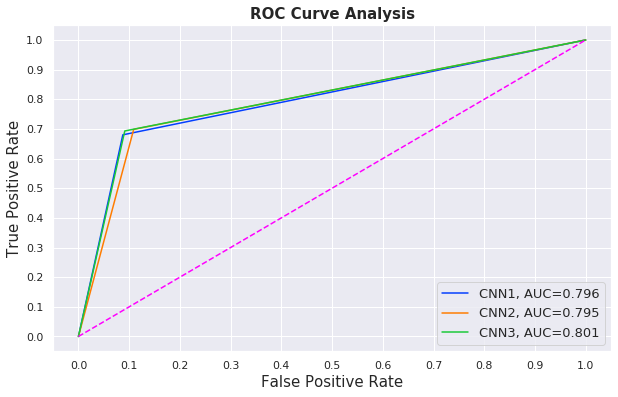

In [ ]:
fig = plt.figure(figsize=(10,6))      # Create the plot of size having height of 10 inches and width of 6 inches

# Apply for loop to extract and plot FP_RATE vs TP_RATE and AUC_SCORE froom the dataframe MODEL_PERFROMANCE_DF
for i in MODEL_PERFROMANCE_DF.index:
    plt.plot(MODEL_PERFROMANCE_DF.loc[i]['FP_RATE'], 
             MODEL_PERFROMANCE_DF.loc[i]['TP_RATE'], 
             label="{}, AUC={:.3f}".format(MODEL_PERFROMANCE_DF.loc[i]['MODEL_NAME'], MODEL_PERFROMANCE_DF.loc[i]['AUC_SCORE']))
    
plt.plot([0,1], [0,1], color='magenta', linestyle='--')                         # plot the orange dashed line connecting the point (0,0) and (1,1)

plt.xticks(np.arange(0.0, 1.1, step=0.1))                                       # plotting the values on X-axis from 0.0 to 1.1 increasing in the step size of 0.1
plt.xlabel("False Positive Rate", fontsize=15)                                  # Provide the appropriate label to the x axis

plt.yticks(np.arange(0.0, 1.1, step=0.1))                                       # plotting the values on Y-axis from 0.0 to 1.1 increasing in the step size of 0.1
plt.ylabel("True Positive Rate", fontsize=15)                                   # Provide the appropriate label to the y axis

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)                 # Provide the appropriate title to the plot
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

**Interpretation**   
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the Cancer and No Cancer. Since, third model CNN3 shows the higher AUC score, model 3 is better as compared to other two models.